In [ ]:
#import packages
import io
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import files

#SN_d_tot_V2.0.csv DataSet from  http://www.sidc.be/silso/datafiles

uploaded = files.upload()
dataSunspots = pd.read_csv(io.BytesIO(uploaded['SN_d_tot_V2.0.csv']), header=None, sep= ';')

Saving SN_d_tot_V2.0.csv to SN_d_tot_V2.0 (2).csv


In [ ]:
from datetime import datetime
dataSunspots.tail()

,0,1,2,3,4,5,6,7
74199,2021,2,24,2021.149,38,7.2,43,0
74200,2021,2,25,2021.152,34,5.3,43,0
74201,2021,2,26,2021.155,19,2.8,45,0
74202,2021,2,27,2021.158,17,1.6,40,0
74203,2021,2,28,2021.160,13,3.4,37,0


In [ ]:
# to Get more information about DataFrame
dataSunspots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74204 entries, 0 to 74203
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       74204 non-null  int64  
 1   1       74204 non-null  int64  
 2   2       74204 non-null  int64  
 3   3       74204 non-null  float64
 4   4       74204 non-null  int64  
 5   5       74204 non-null  float64
 6   6       74204 non-null  int64  
 7   7       74204 non-null  int64  
dtypes: float64(2), int64(6)
memory usage: 4.5 MB


In [ ]:
dataSunspots.columns = ["Year", "Month", "Day", "Date in fraction of year", "no_of_sunspots", "standard deviation", "Number of observations", "Definitive/Provisional Indicator"]
dataSunspots.tail()





,Year,Month,Day,Date in fraction of year,no_of_sunspots,standard deviation,Number of observations,Definitive/Provisional Indicator
74199,2021,2,24,2021.149,38,7.2,43,0
74200,2021,2,25,2021.152,34,5.3,43,0
74201,2021,2,26,2021.155,19,2.8,45,0
74202,2021,2,27,2021.158,17,1.6,40,0
74203,2021,2,28,2021.160,13,3.4,37,0


In [ ]:
dataSunspots['Date'] = dataSunspots.apply(lambda row: datetime.strptime(f"{int(row.Year)}-{int(row.Month)}-{int(row.Day)}", '%Y-%m-%d'), axis=1)
dataSunspots.drop(columns=["Year", "Month", "Day", "Date in fraction of year", "standard deviation", "Number of observations", "Definitive/Provisional Indicator"], axis = 1, inplace=True)
columns_titles = ["Date", "no_of_sunspots"]
df_reorder=dataSunspots.reindex(columns=columns_titles)
df_reorder.no_of_sunspots.loc[df_reorder.no_of_sunspots.astype(int) < 0] = np.nan
df_reorder["no_of_sunspots"] = df_reorder.no_of_sunspots.bfill()
df_reorder

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Date,no_of_sunspots
0,1818-01-01,65.0
1,1818-01-02,65.0
2,1818-01-03,65.0
3,1818-01-04,65.0
4,1818-01-05,65.0
...,...,...
74199,2021-02-24,38.0
74200,2021-02-25,34.0
74201,2021-02-26,19.0
74202,2021-02-27,17.0


In [ ]:
#grouping by Year and Month, and calculating Monthly Mean Total Sunspot Number  
df_reorder['Year'] = pd.to_datetime(df_reorder['Date']).dt.strftime('%Y-%m')
print(df_reorder.groupby('Year', as_index=False)['no_of_sunspots'].mean())


         Year  no_of_sunspots
0     1818-01       49.483871
1     1818-02       48.428571
2     1818-03       39.290323
3     1818-04       49.233333
4     1818-05       84.967742
...       ...             ...
2433  2020-10       14.354839
2434  2020-11       34.000000
2435  2020-12       21.774194
2436  2021-01       10.387097
2437  2021-02        8.250000

[2438 rows x 2 columns]


In [ ]:
df_reorder.isna().sum()

Date              0
no_of_sunspots    0
Year              0
dtype: int64

In [ ]:
Sunspots = df_reorder['no_of_sunspots']
series = np.array(Sunspots)
time = np.arange(0, 74204)
time1 = np.array(time)

In [ ]:
#Function to plot series Data
def plotter(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time (Months)")
    plt.ylabel("No. of Sunspots")
    plt.grid(True)


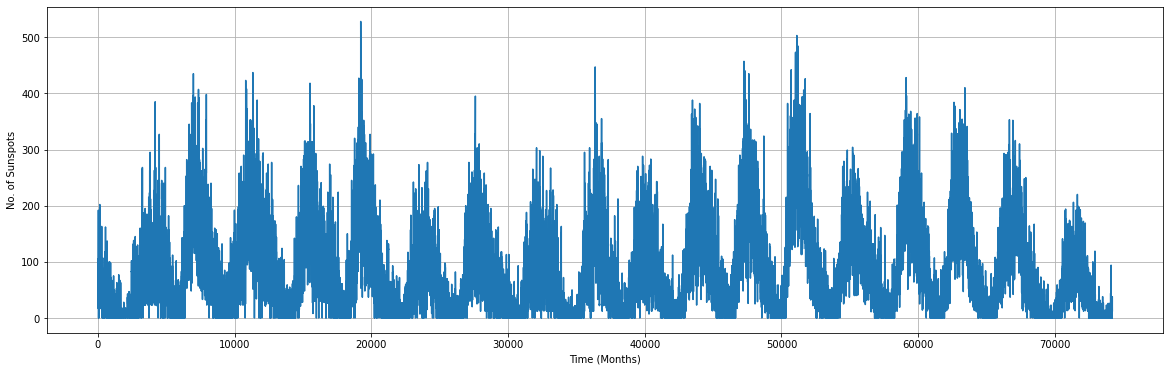

In [ ]:
#Plotting the Data
plt.figure(figsize = (20, 6))
plotter(time, series)

In [ ]:
#Defining Paramters
window_size = 100
batch_size = 256
shuffle_buffer_size = 1000

In [ ]:
#Windowing the DataSet
def train_data_pipeline(series, window_size, batch_size, shuffle_buffer_size):
    series = tf.expand_dims(series, axis=-1)
    data = tf.data.Dataset.from_tensor_slices(series)
    data = data.window(window_size+1, shift=1, drop_remainder=True)
    data = data.flat_map(lambda w: w.batch(batch_size))
    data = data.shuffle(shuffle_buffer_size)
    data = data.map(lambda w: (w[:-1], w[1:]))
    return data.batch(batch_size).prefetch(1)

train = train_data_pipeline(series, window_size, batch_size, shuffle_buffer_size)

In [ ]:
#Clearing the Session
tf.keras.backend.clear_session()

# The model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])
#Summary of the Model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 64)          384       
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          33024     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense (Dense)                (None, None, 32)          2080      
_________________________________________________________________
dense_1 (Dense)              (None, None, 16)          528       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           1

In [ ]:
#Compiling and Training the Model
model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=["mae"])
history = model.fit(train, epochs=50, verbose=0)

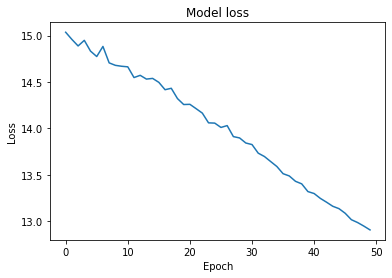

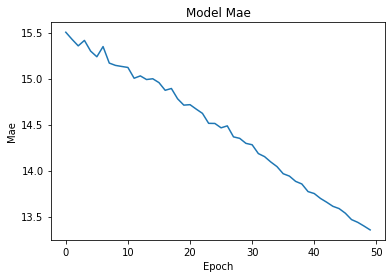

In [ ]:
# Plotting loss values
plt.plot(history.history['loss'][0:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Plotting mae values
plt.plot(history.history['mae'][0:])
plt.title('Model Mae')
plt.ylabel('Mae')
plt.xlabel('Epoch')
plt.show()

In [ ]:
#Windowing Data for Testing
def test_data_pipeline(series):
    series = tf.expand_dims(series, axis=-1)
    data = tf.data.Dataset.from_tensor_slices(series)
    data = data.window(window_size, shift=1, drop_remainder=True)
    data = data.flat_map(lambda w: w.batch(window_size))
    data = data.batch(batch_size).prefetch(1)
    return data

In [ ]:
# Predicting on the same dataset
test = test_data_pipeline(series)
forecast = model.predict(test)
forecast = forecast[:, -1, 0]

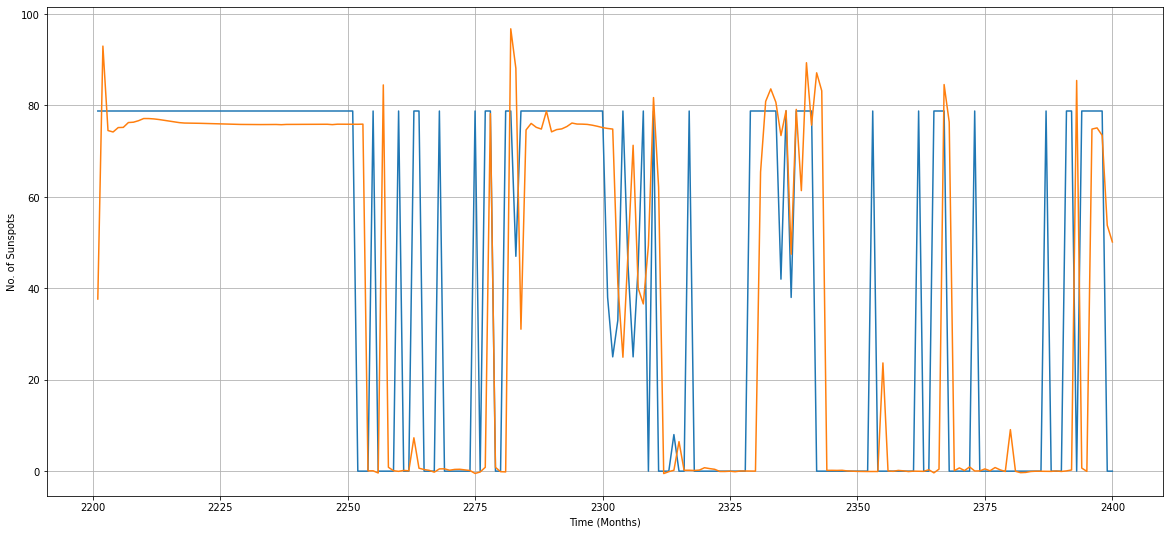

In [ ]:
# Forecasting sunspots using the trained model
time_valid = time[window_size+1:]
series_ori = series[window_size+1:]
forecast = np.reshape(forecast, (-1))
forecast = forecast[:-1]
plt.figure(figsize=(20, 9))
plotter(time_valid[2100:2300], series_ori[2100:2300])
plotter(time_valid[2100:2300], forecast[2100:2300])

In [ ]:
#Monthly Mean: No_of_SunSpots
df_reorder1 = df_reorder.groupby('Year', as_index=False)['no_of_sunspots'].mean()
print(df_reorder1)

         Year  no_of_sunspots
0     1818-01       49.483871
1     1818-02       48.428571
2     1818-03       39.290323
3     1818-04       49.233333
4     1818-05       84.967742
...       ...             ...
2433  2020-10       14.354839
2434  2020-11       34.000000
2435  2020-12       21.774194
2436  2021-01       10.387097
2437  2021-02        8.250000

[2438 rows x 2 columns]


In [ ]:
#Importing the packages
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import time
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.arima_model import ARIMA
# Simple Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn import metrics

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Exploring the DataSet
df_reorder1

,Year,no_of_sunspots
0,1818-01,49.483871
1,1818-02,48.428571
2,1818-03,39.290323
3,1818-04,49.233333
4,1818-05,84.967742
...,...,...
2433,2020-10,14.354839
2434,2020-11,34.000000
2435,2020-12,21.774194
2436,2021-01,10.387097


In [ ]:
#Creating a new column called nth_year where each value in the column is an integer which represents 1 if it is 1st year of the decade or 
#2 if it is 2nd year of the decade and so on. 
df_reorder1['nth_year'] = [str(d)[3] for d in df_reorder1.Year]
df_reorder1['nth_year']=df_reorder1['nth_year'].replace('0','10')
df_reorder1

,Year,no_of_sunspots,nth_year
0,1818-01,49.483871,8
1,1818-02,48.428571,8
2,1818-03,39.290323,8
3,1818-04,49.233333,8
4,1818-05,84.967742,8
...,...,...,...
2433,2020-10,14.354839,10
2434,2020-11,34.000000,10
2435,2020-12,21.774194,10
2436,2021-01,10.387097,1


Text(0, 0.5, 'No. of Sunspots')

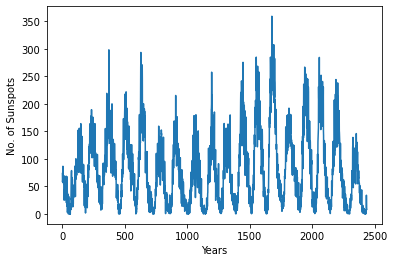

In [ ]:
#Converting date column to datetime object and nth_year to float type.
df_reorder1['Year1'] = pd.to_datetime(df_reorder1['Year'])
df_reorder1['nth_year'] = df_reorder1['nth_year'].astype(float)
plt.plot(df_reorder1['no_of_sunspots'])
plt.xlabel("Years")
plt.ylabel("No. of Sunspots")

#With regards to plot, some seasonality is seen over there. By looking closer we can observe that after every 8-9 years the pattern is 
#repeating. Also we can observe that after a specific period of time the number of sunspots start to decrease and then start to increase. 

In [ ]:
#Extracting Year1 and Month1 from the Year column. Other features are required for easier access and faster calculation purpose.
df_reorder1['Year1'] = pd.DatetimeIndex(df_reorder1['Year']).year
df_reorder1['year3'] = pd.to_datetime(df_reorder1.Year)
df_reorder1['Month1'] = [d.strftime('%b') for d in df_reorder1.year3]
df_reorder1

,Year,no_of_sunspots,nth_year,Year1,year3,Month1
0,1818-01,49.483871,8,1818,1818-01-01,Jan
1,1818-02,48.428571,8,1818,1818-02-01,Feb
2,1818-03,39.290323,8,1818,1818-03-01,Mar
3,1818-04,49.233333,8,1818,1818-04-01,Apr
4,1818-05,84.967742,8,1818,1818-05-01,May
...,...,...,...,...,...,...
2433,2020-10,14.354839,10,2020,2020-10-01,Oct
2434,2020-11,34.000000,10,2020,2020-11-01,Nov
2435,2020-12,21.774194,10,2020,2020-12-01,Dec
2436,2021-01,10.387097,1,2021,2021-01-01,Jan


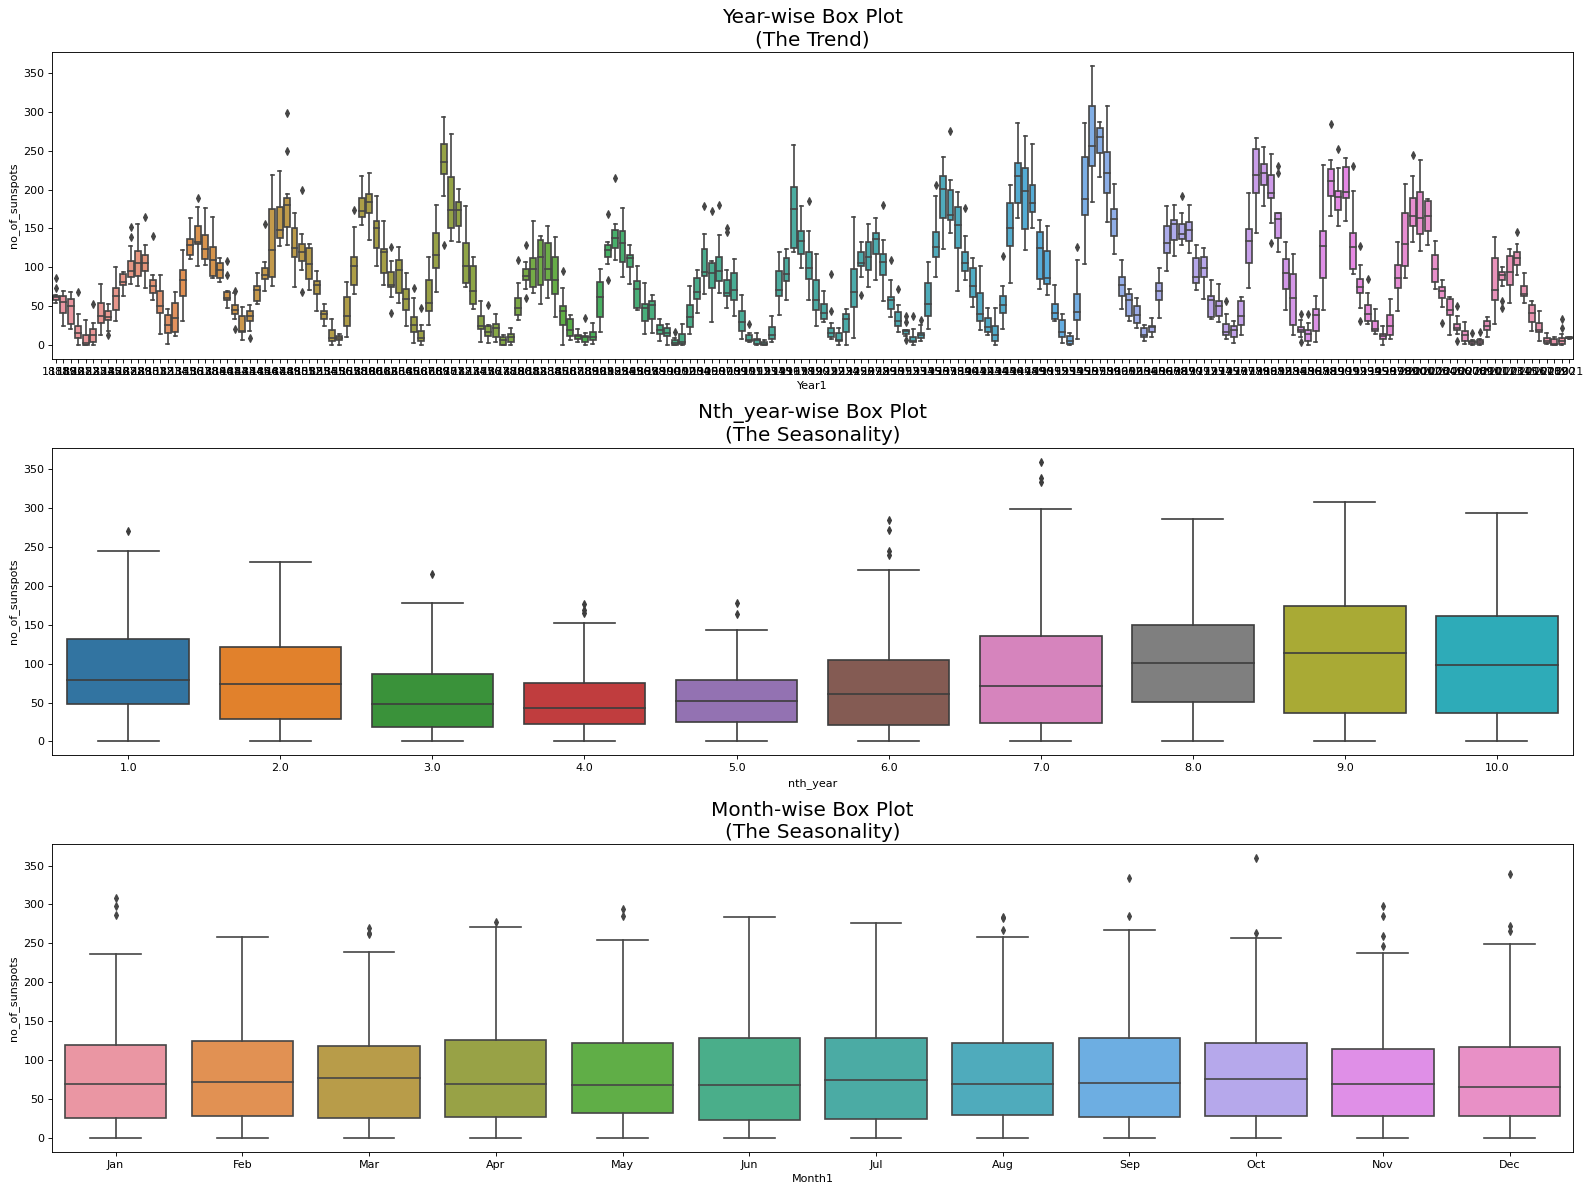

In [ ]:
#Boxplot is necessary to observe the trend and seasonality clearly. 
fig, axes = plt.subplots(3, 1, figsize=(20,15), dpi= 80)
sns.boxplot(x='Year1', y='no_of_sunspots', data=df_reorder1, ax=axes[0])
sns.boxplot(x='nth_year', y='no_of_sunspots', data=df_reorder1,ax = axes[1])
sns.boxplot(x='Month1', y='no_of_sunspots', data=df_reorder1,ax = axes[2])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 

axes[1].set_title('Nth_year-wise Box Plot\n(The Seasonality)', fontsize=18)

axes[2].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
fig.tight_layout()
plt.show()

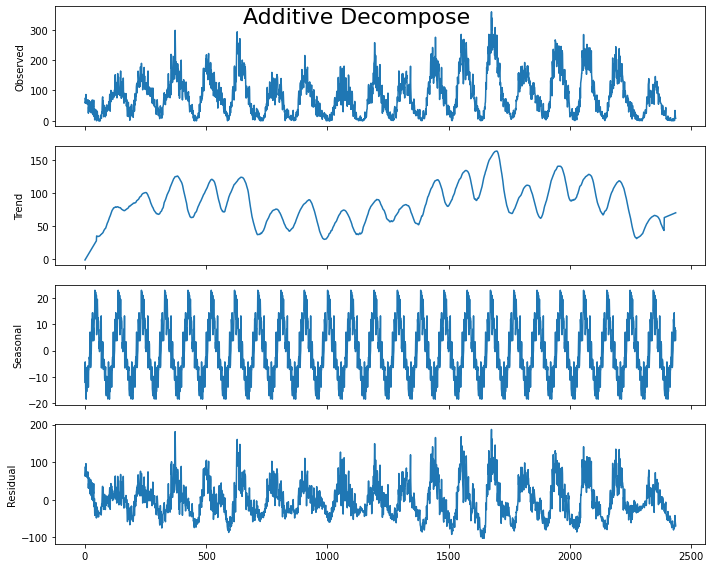

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Additive Decomposition
result_add = seasonal_decompose(df_reorder1['no_of_sunspots'], model='additive', extrapolate_trend='freq',freq=96)

# Plot
plt.rcParams.update({'figure.figsize': (10,8)})
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [ ]:
df_reorder1['rolling_mean'] = df_reorder1['no_of_sunspots'].rolling(12).mean()
df_reorder1['Detrend'] = df_reorder1['no_of_sunspots'] - df_reorder1['rolling_mean']
df_reorder1

,Year,no_of_sunspots,nth_year,Year1,year3,Month1,rolling_mean,Detrend
0,1818-01,49.483871,8,1818,1818-01-01,Jan,NaN,NaN
1,1818-02,48.428571,8,1818,1818-02-01,Feb,NaN,NaN
2,1818-03,39.290323,8,1818,1818-03-01,Mar,NaN,NaN
3,1818-04,49.233333,8,1818,1818-04-01,Apr,NaN,NaN
4,1818-05,84.967742,8,1818,1818-05-01,May,NaN,NaN
...,...,...,...,...,...,...,...,...
2433,2020-10,14.354839,10,2020,2020-10-01,Oct,4.133102,10.221737
2434,2020-11,34.000000,10,2020,2020-11-01,Nov,6.927546,27.072454
2435,2020-12,21.774194,10,2020,2020-12-01,Dec,8.615718,13.158475
2436,2021-01,10.387097,1,2021,2021-01-01,Jan,8.965180,1.421916


Text(0.5, 1.0, 'Detrended')

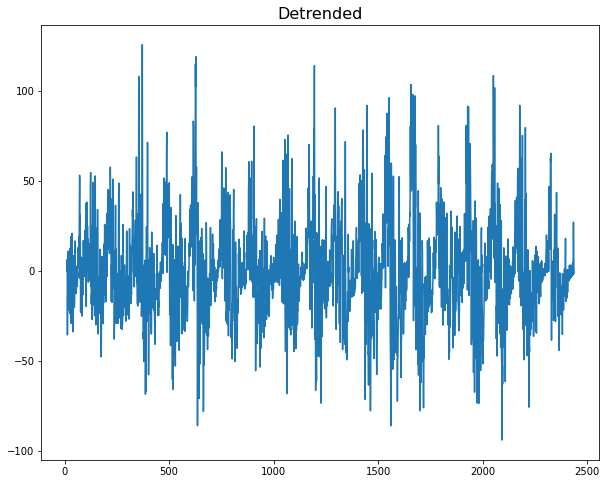

In [ ]:
plt.plot(df_reorder1['Detrend'])
plt.title('Detrended',fontsize=16)

Text(0.5, 1.0, 'Detrended by subtracting the trend component')

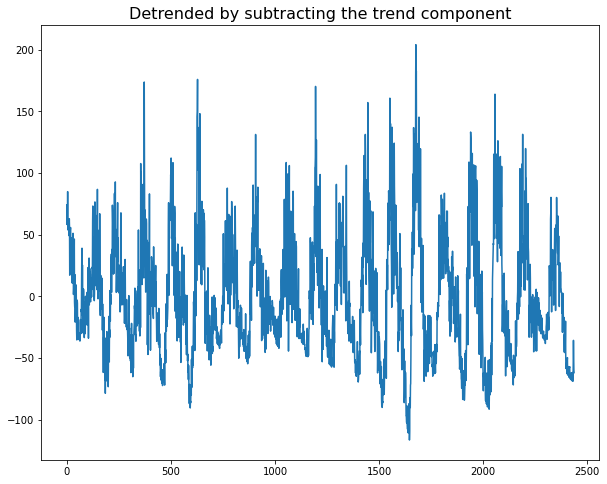

In [ ]:
#Detrending using seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose
result_add = seasonal_decompose(df_reorder1['no_of_sunspots'], model='add', extrapolate_trend='freq',freq=96)
detrended = df_reorder1.no_of_sunspots.values -result_add.trend
plt.plot(detrended)
plt.title('Detrended by subtracting the trend component', fontsize=16)

Text(0.5, 1.0, 'Deseasonalization by subtracting the seasonal component')

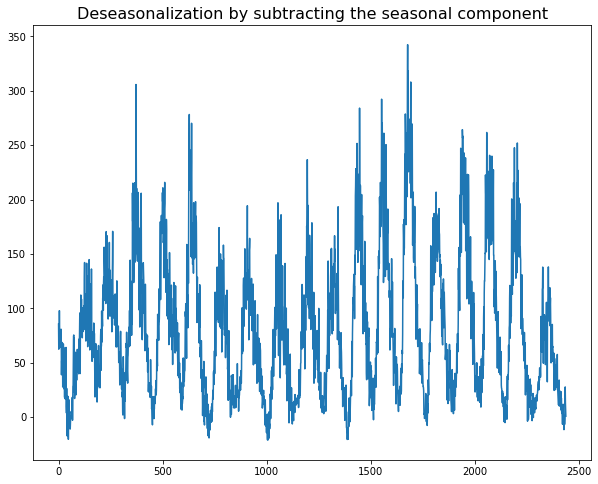

In [ ]:
##Deseasonalizing using seasonal decompose
from statsmodels.tsa.seasonal import seasonal_decompose
result_add = seasonal_decompose(df_reorder1['no_of_sunspots'], model='add', extrapolate_trend='freq',freq=96)
deseasonalized = df_reorder1.no_of_sunspots.values -result_add.seasonal
plt.plot(deseasonalized)
plt.title('Deseasonalization by subtracting the seasonal component', fontsize=16)

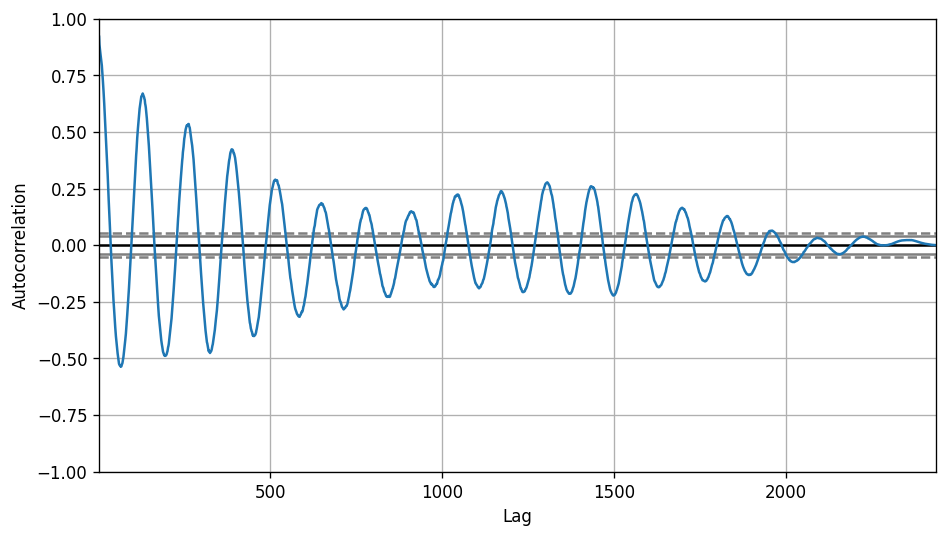

In [ ]:
from pandas.plotting import autocorrelation_plot

# Draw Plot: Autocorrelation plot. This is useful to find if current value depends on previous values
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(df_reorder1['no_of_sunspots'].tolist())

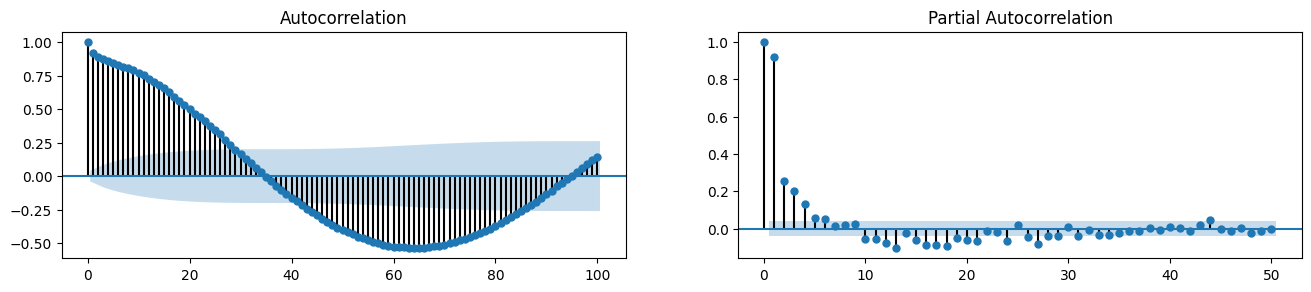

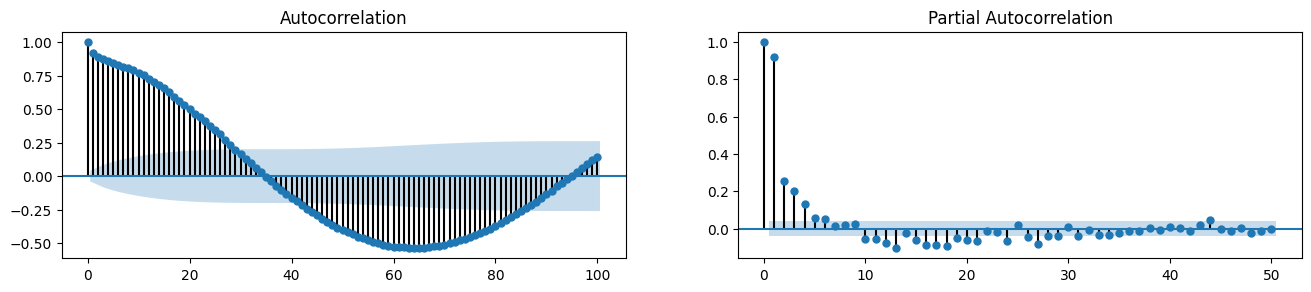

In [ ]:
#Using "acf plot" we can understand whether the data in additive or multiplicatve. By looking at the plot we can improvise our understanding from below plot.
#With the help of "pacf plot" one can know that the present value depends only on previous 6 values.
#At the end, all these plots help us narrow down thinking and make our model efficient.

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df_reorder1['no_of_sunspots'].tolist(), lags=100, ax=axes[0])
plot_pacf(df_reorder1['no_of_sunspots'].tolist(), lags=50, ax=axes[1])

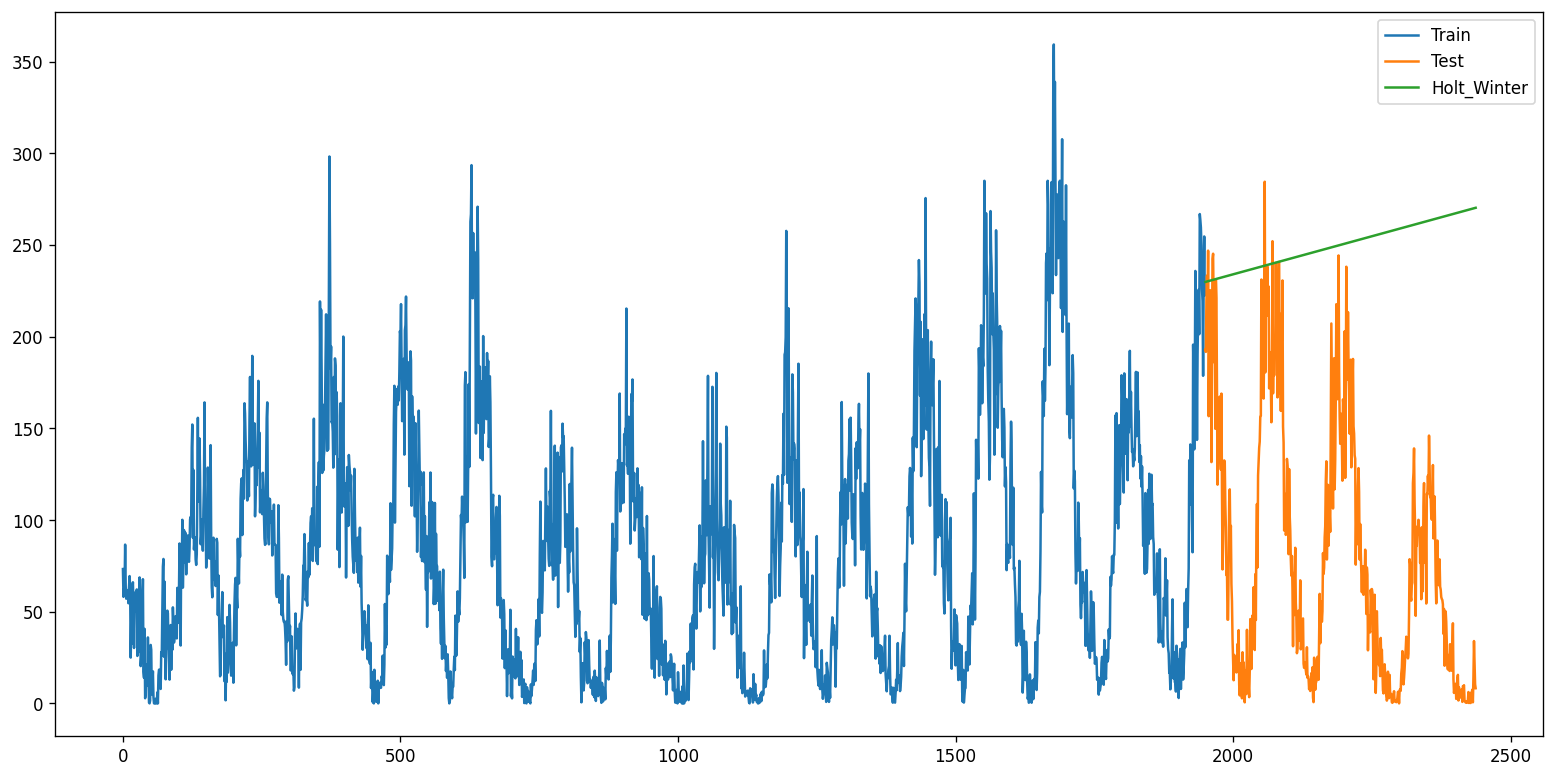

In [ ]:
count = int(df_reorder1.shape[0]*0.8)
Train = df_reorder1[:count]
Test = df_reorder1[count:]

y_hat_avg = Test.copy()
fit1 = Holt(np.asarray(Train['no_of_sunspots'])).fit()
y_hat_avg['Holt_Winter'] = fit1.predict(start=count+1,end=df_reorder1.shape[0])
plt.figure(figsize=(16,8))
plt.plot(Train.index, Train['no_of_sunspots'], label='Train')
plt.plot(Test.index,Test['no_of_sunspots'], label='Test')
plt.plot(y_hat_avg.index,y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
# plt.savefig('Holt_Winters.jpg')

In [ ]:
#new = df_reorder1[['Year', 'no_of_sunspots']]
df_reorder1 = df_reorder1.set_index('year3') 
new = df_reorder1[['no_of_sunspots']]
new

,no_of_sunspots
year3,
1818-01-01,49.483871
1818-02-01,48.428571
1818-03-01,39.290323
1818-04-01,49.233333
1818-05-01,84.967742
...,...
2020-10-01,14.354839
2020-11-01,34.000000
2020-12-01,21.774194


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:939: RuntimeWarning: invalid value encountered in double_scalars
  'initial_slope': b[0] / phi,


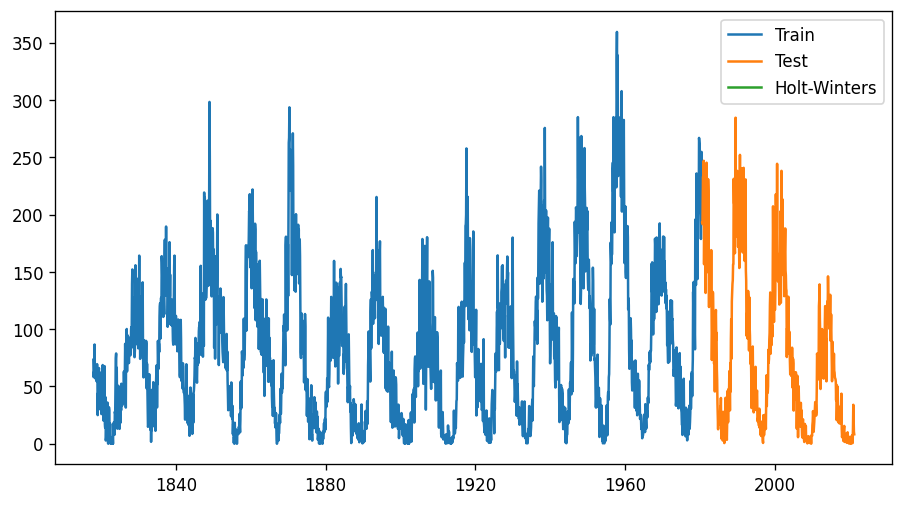

In [ ]:
Train, Test = new.iloc[:count, 0], df_reorder1.iloc[count:, 0]

model = ExponentialSmoothing(Train, trend='add', seasonal='add', seasonal_periods=12, damped=True)
hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=False)
pred = hw_model.predict(start=Test.index[0], end=Test.index[-1])

plt.plot(Train.index, Train, label='Train')
plt.plot(Test.index, Test, label='Test')
plt.plot(pred.index, pred, label='Holt-Winters')
plt.legend(loc='best');

In [ ]:
history = [ x for x in Train]
print(history) 

[73.27309363053604, 58.10503137146937, 62.331785559491756, 63.90111406097686, 86.60286928665174, 63.796915219061226, 57.09080364979591, 61.85794853090453, 57.54592985908026, 60.32365876868728, 54.60222812195373, 63.77634979543909, 69.44672048299932, 63.00238727352185, 24.97586872628835, 44.24901464001905, 32.61290322580645, 63.049014640019045, 66.04851164612506, 51.43453029679263, 30.21148246477007, 55.45269102675179, 55.35321348193468, 60.79343240187227, 50.1089643797551, 62.16284033501758, 25.879094532739963, 49.31988014860134, 59.503109821227106, 28.063581885727896, 68.70179972725212, 59.22389930326268, 20.330248552394558, 25.19056311522054, 50.37617841147482, 45.894269990822906, 67.74110645904672, 17.254498759195336, 13.985902665443055, 40.645929859080276, 2.806451612903226, 5.4927163771455785, 21.07969158711521, 19.448627631349574, 9.659383043812246, 35.97885399816458, 14.478149131436734, 0.41935483870967744, 0.0, 1.5, 31.882079804616197, 29.27086550858231, 4.89617713917314, 11.62

In [ ]:
predictions = list()
lower_list = []
upper_list = []
#Test = df_reorder1.iloc[count:, 0]
#print(Test)
for x in range(len(Test)):
    model = ARIMA(history, order=(5,1,0))
    print(x) 
    print(len(Test))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    lower = output[2][0][0]
    upper = output[2][0][1]
    predictions.append(yhat)
    lower_list.append(lower)
    upper_list.append(upper)
    #Test[t]
    obs = Test[x]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
   

0
488
predicted=223.861423, expected=192.935484
1
488
predicted=207.601823, expected=191.709677
2
488
predicted=200.884814, expected=219.566667
3
488
predicted=216.208030, expected=233.258065
4
488
predicted=225.232620, expected=209.533333
5
488
predicted=212.051215, expected=246.935484
6
488
predicted=234.217743, expected=156.645161
7
488
predicted=182.386126, expected=189.892857
8
488
predicted=198.285302, expected=196.645161
9
488
predicted=198.448754, expected=225.333333
10
488
predicted=212.769967, expected=194.677419
11
488
predicted=200.132103, expected=131.600000
12
488
predicted=157.588238, expected=205.322581
13
488
predicted=197.192704, expected=242.451613
14
488
predicted=218.700217, expected=245.266667
15
488
predicted=227.967561, expected=216.161290
16
488
predicted=216.522638, expected=186.033333
17
488
predicted=197.796479, expected=195.387097
18
488
predicted=203.707927, expected=149.774194
19
488
predicted=173.561490, expected=230.928571
20
488
predicted=215.827434, e

In [ ]:
error = metrics.mean_squared_error(Test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 525.867


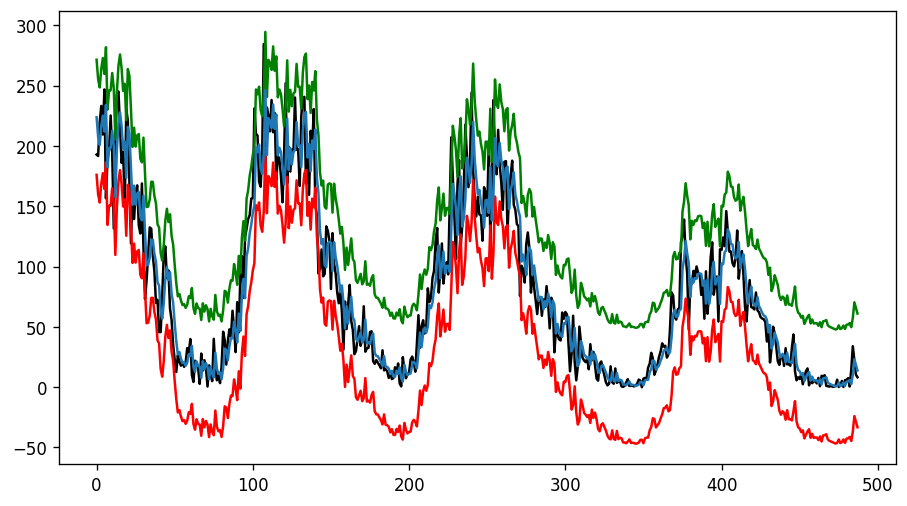

In [ ]:
#plot for orginal test data values, predicted values and confidance interval.
plt.plot(Test.values,color='black')
plt.plot(lower_list,color='red')
plt.plot(upper_list,color='green')
plt.plot(predictions)
plt.show()